# Import Libraries

#### Modeling and Modeling Metrics Libraries 

In [7]:
# Models and Transformers
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression

# Model Metrics
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay, f1_score
from sklearn import metrics

# Optimization
from sklearn.model_selection import GridSearchCV

#### Data Visualization

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#### File Management

In [9]:
import os
import subprocess
import glob

import json
import csv

#### NLP & Text Parsing

In [10]:
import re
from textblob import TextBlob

#### Pandas/NumPy/Datetime

In [11]:
import pandas as pd
import numpy as np

from datetime import datetime, date, time

#### Twitter/Stock Data Scraper

In [12]:
import snscrape.modules.twitter as sntwitter
import yfinance as yf

# Custom Functions

In [1]:
# Get Twitter Data (Saved as csv on local machine)

def scrapeTweets(start_date, end_date, keyword, current_dir, tweet_limit=1, iteration=0):
    if not os.path.exists(current_dir):  # Creates directory in current directory if doesn't already exist
        os.mkdir(current_dir)

    file_path = os.path.join(current_dir, f'keyword:{keyword}__start:{start_date}_end:{end_date}__iter:{iteration}.csv')

    tweet_list = []
    for i, tweet in enumerate(
            sntwitter.TwitterSearchScraper(f'{keyword} since:{start_date} until:{end_date}').get_items()):
        if i > tweet_limit:
            break
        tweet_list.append([tweet.date,  # Appending all tweet data into a list of list
                           tweet.id,
                           tweet.content,
                           tweet.user.username,
                           tweet.user.followersCount,
                           tweet.hashtags,
                           tweet.cashtags,
                           tweet.lang,
                           tweet.retweetCount,
                           tweet.likeCount,
                           tweet.replyCount])

    df_tweets = pd.DataFrame(tweet_list, columns=['Datetime',  # Creating df of tweet data
                                                  'Tweet Id',
                                                  'Text',
                                                  'Username',
                                                  'Followers Count',
                                                  'Hashtags',
                                                  'Cashtags',
                                                  'Language',
                                                  'Retweet Count',
                                                  'Likes Count',
                                                  'Reply Count'])

    for i in range(1001):
        if not os.path.isfile(file_path):
            df_tweets.to_csv(file_path, index=False)
            break
        else:
            file_path = os.path.join(current_dir,
                                     f'keyword:{keyword}__start:{start_date}_end:{end_date}__limit:{tweet_limit}__iter:{i + 1}.csv')

    if os.path.isfile(file_path):
        return print(f'Successfully saved DataFrame to {file_path}')
    return print('DataFrame not saved -- possible error has occurred.')

In [14]:
# Wrangle Tweet Data

def dataWrangle(dataframe_list):   
    df_concat = pd.concat(dataframe_list) # Concatenate all the DataFrames from the list of DataFrames
    df_filter = df_concat[df_concat['Language'] == 'en'][['Datetime', # Filter via Language = 'en'
                                                           'Tweet Id', # Remove unwanted columns
                                                           'Text', 
                                                           'Username',
                                                           'Followers Count']] 
    df_clean = df_filter.astype({'Tweet Id':str})\
                        .dropna()\
                        .drop_duplicates()\
                        .reset_index(drop=True)
    
    df_clean['Text'] = (df_clean['Text'] # Cleans out redundant string characters within each tweet
                       .apply(lambda x: ' '.join(re.sub(r'https\S+', '', x)
                                                .replace('\n', ' ')
                                                .split()
                                                )
                             )
                       )
    
    df_clean['Datetime'] = pd.to_datetime(df_clean['Datetime']).dt.floor('d').dt.tz_localize(tz=None)
    
    return df_clean.set_index('Datetime').sort_index()
                                               

In [15]:
# Get Stock Data (DataFrame)

def getStockData(ticker, start, end):
    df_stock = yf.download(ticker, start, end)
    df_stock.index = df_stock.index.tz_localize(tz=None).rename(name='Datetime')
    df_stock['Closing Differences'] = df_stock['Adj Close'].diff()
    df_stock['C-O/O'] = ((df_stock['Close']-df_stock['Open'])/df_stock['Open'])*100
    
    return df_stock    

In [16]:
# CLASSIFICATION Model Evaluation

def model_evaluation(model, X, y_true, positive_label):
    y_pred = model.predict(X)
    scores = {}
    scores['accuracy'] = round(metrics.accuracy_score(y_true, y_pred), 4)
    scores['precision'] = round(metrics.precision_score(y_true, y_pred, pos_label=positive_label), 4)
    scores['recall'] = round(metrics.recall_score(y_true, y_pred, pos_label=positive_label), 4)
    probs = model.predict_proba(X).T[1]
    precisions, recalls, thresholds = metrics.precision_recall_curve(y_true, probs, pos_label=positive_label)
    scores['area under precision-recall curve'] = round(metrics.auc(recalls, precisions), 4)
    scores['f1 score'] = round(f1_score(y_true=y_true, y_pred=y_pred, pos_label= "Positive_Trend"), 4)
    return scores

def print_model_evaluation(model_name, scores):
#     print('{} evaluation \n'.format(model_name))
    for metric, score in scores.items():
        print('Test {}: {}'.format(metric, score))


In [75]:
# 1. Polarity Score Categories as a column on DataFrame
# 2. Creating categorical polarity column

def polarityCategories(tup):
    if tup[0] < -0.05:
        return 'Negative'
    elif tup[0] > 0.05:
        return 'Positive'
    else:
        return 'Neutral'
    
def polarityColumns(df_tweets):
    df_tweets['Polarity/Subjectivity Scores'] = df_tweets['Text'].apply(lambda text: TextBlob(text).sentiment)
    df_tweets_filtered = df_tweets[df_tweets['Polarity/Subjectivity Scores'] != (0.0,0.0)]
    df_tweets_filtered = df_tweets_filtered.copy()
    df_tweets_filtered['Polarity Categories'] = df_tweets_filtered['Polarity/Subjectivity Scores'].apply(lambda x: polarityCategories(x))
    
    print(df_tweets_filtered.value_counts('Polarity Categories'))
    
    return df_tweets_filtered

# Twitter Data

## GME Tweets

In [ ]:
start_time = date(2021, 1, 8).strftime('%Y-%m-%d')
stop_time = date(2021, 2, 12).strftime('%Y-%m-%d')

In [171]:
# Creating a list of DataFrames using glob's list of files names
df_tweet_gme_list = []
for i in glob.glob('tweets_GME/*'):
    df_tweet_gme_list.append(pd.read_csv(i))

In [172]:
df_tweet_gme = dataWrangle(df_tweet_gme_list)

In [186]:
df_tweet_gme[df_tweet_gme['Tweet Id'] == str(1359867168431738887)]['Text'][0]

"#wallstreetbets JIM CRAMER ON CNBC! Dude I will explain this again because you can't understand how #gme isn't screwing stockholders(customers). I mean that sentence says it all really man. Some things are more important than money. like public perception #amc #protestbucks"

In [174]:
df_tweet_gme.value_counts('Datetime').sort_index()

Datetime
2021-01-01     1086
2021-01-02     1106
2021-01-03     1215
2021-01-04     1212
2021-01-05     1183
2021-01-06     1781
2021-01-07     2937
2021-01-08     2142
2021-01-09     1224
2021-01-10     1140
2021-01-11     2203
2021-01-12     1470
2021-01-13     3708
2021-01-14     3209
2021-01-15     1858
2021-01-16     2341
2021-01-17     2188
2021-01-18     2506
2021-01-19     2857
2021-01-20     2934
2021-01-21     6150
2021-01-22     7159
2021-01-23     3036
2021-01-24     2072
2021-01-25     1572
2021-01-26     2689
2021-01-27     9156
2021-01-28    13598
2021-01-29     7467
2021-01-30     3151
2021-01-31     2180
2021-02-01     5938
2021-02-02     5787
2021-02-03     3412
2021-02-04     2207
2021-02-05    10187
2021-02-06     5629
2021-02-07     4955
2021-02-08     6579
2021-02-09     6395
2021-02-10     7605
2021-02-11     5607
dtype: int64

# Polarity Scores

A list of goals to accomplish: \
    - Figure out polarity/subjectivity scores for every tweet\
    - For now we want to work with dates from 01/21/2021 and onwards as a test\
    - Mess about with distribution of negative/positive/neutral scores to have a healthy balance of samples\
    - Break everything up by days\
    - Move onto bringing in financial data

In [187]:
df_tweet_gme = polarityColumns(df_tweet_gme)

Polarity Categories
Positive    61931
Negative    27257
Neutral     22914
dtype: int64


In [188]:
df_tweet_gme

,Tweet Id,Text,Username,Followers Count,Polarity/Subjectivity Scores,Polarity Categories
Datetime,,,,,,
2021-01-01,1345092820038770688,@toypixx @SerpentorsLair @GIJoeOfficial @Hasbr...,RedRangerChris,412,"(0.0, 1.0)",Neutral
2021-01-01,1344798527243878400,@HennepinHC_GME @rita_hurd You know I was thin...,londyloo,24884,"(0.2, 0.30000000000000004)",Positive
2021-01-01,1344799360463331328,@HennepinHC_GME @rita_hurd Oh my gosh! that gi...,londyloo,24884,"(-0.4, 0.4)",Negative
2021-01-01,1344799762797703168,@rita_hurd @HennepinHC_GME For real tho the br...,londyloo,24884,"(0.4, 0.6000000000000001)",Positive
2021-01-01,1345094263776964617,"@frozenow I've fixed the checks on Gamestop, t...",stockbacklive,16901,"(0.15000000000000002, 0.2)",Positive
...,...,...,...,...,...,...
2021-02-11,1359866938286092298,So SoFi uses PFOF. Below is response from them...,alokc83,47,"(-0.25, 0.4166666666666667)",Negative
2021-02-11,1359866811907530752,@DogecoinRise This discord might be the reason...,PhilHar10408856,0,"(0.034999999999999996, 0.195)",Neutral
2021-02-11,1359866775937122311,@CoinDesk @JRossNicoll @langer_hans @AsILayHod...,PhilHar10408856,0,"(0.034999999999999996, 0.195)",Neutral


# Stock Data

## GME

In [189]:
df_stock_gme = getStockData('GME','2021-01-01','2021-02-12')

[*********************100%***********************]  1 of 1 completed


In [190]:
df_stock_gme

,Open,High,Low,Close,Adj Close,Volume,Closing Differences,C-O/O
Datetime,,,,,,,,
2021-01-04,19.000000,19.100000,17.150000,17.250000,17.250000,10022500,NaN,-9.210526
2021-01-05,17.350000,18.080000,17.230000,17.370001,17.370001,4961500,0.120001,0.115276
2021-01-06,17.340000,18.980000,17.330000,18.360001,18.360001,6056200,0.990000,5.882356
2021-01-07,18.469999,19.450001,18.020000,18.080000,18.080000,6129300,-0.280001,-2.111529
2021-01-08,18.180000,18.299999,17.080000,17.690001,17.690001,6482000,-0.389999,-2.695268
2021-01-11,19.410000,20.650000,19.010000,19.940001,19.940001,14908000,2.250000,2.730555
2021-01-12,19.959999,20.400000,19.320000,19.950001,19.950001,7060700,0.010000,-0.050092
2021-01-13,20.420000,38.650002,20.030001,31.400000,31.400000,144501700,11.449999,53.770810
2021-01-14,38.090000,43.060001,33.049999,39.910000,39.910000,93717400,8.510000,4.778156


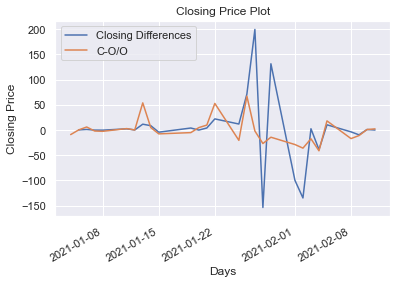

In [191]:
# Plot

df_stock_gme[['Closing Differences', 'C-O/O']].plot()

# plt.ylim(-120, 120)

plt.xlabel('Days')
plt.ylabel('Closing Price')
plt.title('Closing Price Plot');

## AAPL

In [89]:
df_stock_aapl = getStockData('AAPL', '2021-01-01', '2021-03-01')

[*********************100%***********************]  1 of 1 completed


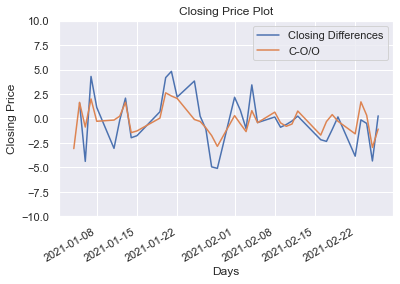

In [96]:
# Plot

df_stock_aapl[['Closing Differences', 'C-O/O']].plot()

plt.ylim(-10, 10)

plt.xlabel('Days')
plt.ylabel('Closing Price')
plt.title('Closing Price Plot');

# Merging Twitter + Stock DataFrames

## GME

In [192]:
# Why is there NaN values for Volume and closing differences?
# Because the stock market is only opened on business days!
# So we dropped NaN values

df_merged_gme = df_stock_gme.merge(df_tweet_gme, how='right', left_index=True, right_index=True).dropna()

In [193]:
df_merged_gme['Closing Trend'] = df_merged_gme['Closing Differences'].apply(lambda x: "Positive_Trend" if x>=0 else "Negative_Trend")

In [214]:
df_merged_gme.sort_index()

,Open,High,Low,Close,Adj Close,Volume,Closing Differences,C-O/O,Tweet Id,Text,Username,Followers Count,Polarity/Subjectivity Scores,Polarity Categories,Closing Trend
Datetime,,,,,,,,,,,,,,,
2021-01-05,17.350000,18.08,17.230000,17.370001,17.370001,4961500.0,0.120001,0.115276,1346478740461690881,@ArsalanSaleemMD This guy. Was just selected a...,UtmbRadiology,456,"(0.25, 0.4375)",Positive,Positive_Trend
2021-01-05,17.350000,18.08,17.230000,17.370001,17.370001,4961500.0,0.120001,0.115276,1346555487345664001,@Nospherato21 @FinnFriede1 @GYXdeals GameStop ...,WhyYouOTF,554,"(0.1, 0.0)",Positive,Positive_Trend
2021-01-05,17.350000,18.08,17.230000,17.370001,17.370001,4961500.0,0.120001,0.115276,1346555775280439299,i pre ordered my copy of super mario 3d all st...,RGONZALEZ1978,436,"(0.26666666666666666, 0.4533333333333333)",Positive,Positive_Trend
2021-01-05,17.350000,18.08,17.230000,17.370001,17.370001,4961500.0,0.120001,0.115276,1346555803491328003,"Check your @GameStop receipts for shady fees, ...",tgccustoms,2636,"(-0.25, 0.625)",Negative,Positive_Trend
2021-01-05,17.350000,18.08,17.230000,17.370001,17.370001,4961500.0,0.120001,0.115276,1346556842093133825,New game a couple days ago #gamestop was kind ...,StratoWave5200,258,"(0.20727272727272722, 0.5709090909090909)",Positive,Positive_Trend
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-11,50.009998,55.32,48.220001,51.099998,51.099998,13056700.0,-0.100002,2.179564,1359866938286092298,So SoFi uses PFOF. Below is response from them...,alokc83,47,"(-0.25, 0.4166666666666667)",Negative,Negative_Trend
2021-02-11,50.009998,55.32,48.220001,51.099998,51.099998,13056700.0,-0.100002,2.179564,1359866811907530752,@DogecoinRise This discord might be the reason...,PhilHar10408856,0,"(0.034999999999999996, 0.195)",Neutral,Negative_Trend
2021-02-11,50.009998,55.32,48.220001,51.099998,51.099998,13056700.0,-0.100002,2.179564,1359866775937122311,@CoinDesk @JRossNicoll @langer_hans @AsILayHod...,PhilHar10408856,0,"(0.034999999999999996, 0.195)",Neutral,Negative_Trend


## AAPL

# Dealing with Imbalances

In [33]:
from imblearn.over_sampling import SMOTE

In [35]:
sampler = SMOTE(random_state=42)

# Modeling

## GME

#### Train/Test Split

In [195]:
X = df_merged_gme
y = df_merged_gme['Closing Trend']

In [226]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [227]:
X_train

,Open,High,Low,Close,Adj Close,Volume,Closing Differences,C-O/O,Tweet Id,Text,Username,Followers Count,Polarity/Subjectivity Scores,Polarity Categories,Closing Trend
Datetime,,,,,,,,,,,,,,,
2021-01-05,17.350000,18.080000,17.23,17.370001,17.370001,4961500.0,0.120001,0.115276,1346478740461690881,@ArsalanSaleemMD This guy. Was just selected a...,UtmbRadiology,456,"(0.25, 0.4375)",Positive,Positive_Trend
2021-01-05,17.350000,18.080000,17.23,17.370001,17.370001,4961500.0,0.120001,0.115276,1346555487345664001,@Nospherato21 @FinnFriede1 @GYXdeals GameStop ...,WhyYouOTF,554,"(0.1, 0.0)",Positive,Positive_Trend
2021-01-05,17.350000,18.080000,17.23,17.370001,17.370001,4961500.0,0.120001,0.115276,1346555775280439299,i pre ordered my copy of super mario 3d all st...,RGONZALEZ1978,436,"(0.26666666666666666, 0.4533333333333333)",Positive,Positive_Trend
2021-01-05,17.350000,18.080000,17.23,17.370001,17.370001,4961500.0,0.120001,0.115276,1346555803491328003,"Check your @GameStop receipts for shady fees, ...",tgccustoms,2636,"(-0.25, 0.625)",Negative,Positive_Trend
2021-01-05,17.350000,18.080000,17.23,17.370001,17.370001,4961500.0,0.120001,0.115276,1346556842093133825,New game a couple days ago #gamestop was kind ...,StratoWave5200,258,"(0.20727272727272722, 0.5709090909090909)",Positive,Positive_Trend
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-08,72.410004,72.660004,58.02,60.000000,60.000000,25687300.0,-3.770000,-17.138521,1358689198547611649,@BakuExchange A pump is something like $GME or...,shinjisumato,69,"(0.55, 0.375)",Positive,Negative_Trend
2021-02-08,72.410004,72.660004,58.02,60.000000,60.000000,25687300.0,-3.770000,-17.138521,1358689231770509314,@TheMightyFred @MaryL80138193 @IMPeachy1331 @C...,gme_posh_pug,2013,"(-0.004166666666666674, 0.3666666666666667)",Neutral,Negative_Trend
2021-02-08,72.410004,72.660004,58.02,60.000000,60.000000,25687300.0,-3.770000,-17.138521,1358689438688137216,@NexusFolf I linked my account before the whol...,Glenn_der_lowe,117,"(0.6, 0.35)",Positive,Negative_Trend


#### Support Vector Machine (Baseline)

In [39]:
transformer_svm = ColumnTransformer([
    ('ohe', OneHotEncoder(), ['Polarity Categories']),
    ('scaler', StandardScaler(), ['Followers Count'])
])

In [42]:
pipe_svm = Pipeline([
    ('ohe', transformer_svm),
    ('svm', svm.LinearSVC())
])

In [44]:
pipe_svm_fit = pipe_svm.fit(X_train, y_train)

C:\Users\Daanish\anaconda3\envs\capstone_environment\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [45]:
pipe_svm_fit.score(X_test, y_test)

0.5198527057316683

#### Random Forest Classifier (Baseline)

In [229]:
transformer_rfc = ColumnTransformer([
    ('ohe', OneHotEncoder(), ['Polarity Categories']),
    ('scaler', StandardScaler(), ['Followers Count'])
])

In [230]:
pipe_rfc = Pipeline([
    ('ohe', transformer_rfc),
    ('randomforest', GridSearchCV(RandomForestClassifier(),
                                  param_grid={},
                                  verbose=3,
                                  n_jobs=4))
])

In [231]:
pipe_rfc_fit = pipe_rfc.fit(X_train.sort_index(), y_train.sort_index())

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [232]:
# shuffle = False
print_model_evaluation(pipe_rfc_fit, model_evaluation(pipe_rfc_fit, X_test, y_test, positive_label='Positive_Trend'))

Test accuracy: 0.3848
Test precision: 0.2985
Test recall: 0.7962
Test area under precision-recall curve: 0.3255
Test f1 score: 0.4342


In [221]:
print_model_evaluation(pipe_rfc_fit, model_evaluation(pipe_rfc_fit, X_test, y_test, positive_label='Positive_Trend'))

Test accuracy: 0.5935
Test precision: 0.623
Test recall: 0.7065
Test area under precision-recall curve: 0.6786
Test f1 score: 0.6621


In [200]:
# model with updated data (more data)
print_model_evaluation(pipe_rfc_fit, model_evaluation(pipe_rfc_fit, X_test, y_test, positive_label='Positive_Trend'))

Test accuracy: 0.5919
Test precision: 0.6234
Test recall: 0.6976
Test area under precision-recall curve: 0.6787
Test f1 score: 0.6584


In [101]:
# old before yesterdays updated data

print_model_evaluation(pipe_rfc_fit, model_evaluation(pipe_rfc_fit, X_test, y_test, positive_label='Positive_Trend'))

Test accuracy: 0.5854
Test precision: 0.576
Test recall: 0.5208
Test area under precision-recall curve: 0.5957
Test f1 score: 0.547


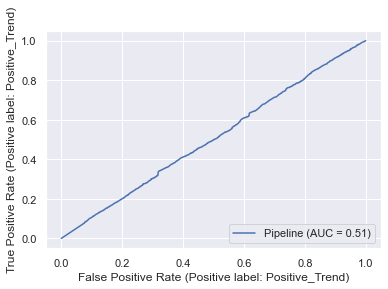

In [240]:
RocCurveDisplay.from_estimator(pipe_rfc_fit, X_test.sort_index(), y_test.sort_index()) 

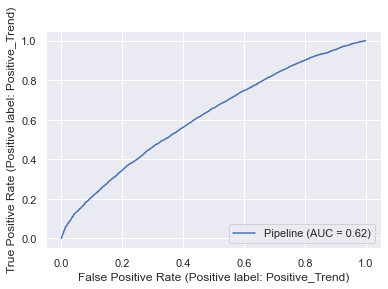

In [201]:
# model with updated data (more data)
RocCurveDisplay.from_estimator(pipe_rfc_fit, X_test, y_test)

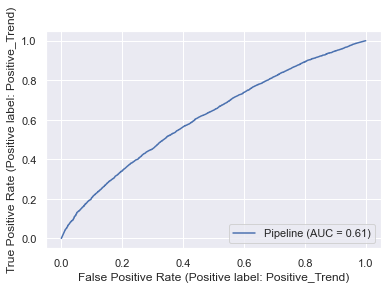

In [105]:
# old before yesterdays updated data
RocCurveDisplay.from_estimator(pipe_rfc_fit, X_test, y_test)

#### Logistic Regression (Baseline)

In [234]:
transformer_logit = ColumnTransformer([
    ('ohe', OneHotEncoder(), ['Polarity Categories']),
    ('scaler', StandardScaler(), ['Followers Count'])
])

In [235]:
pipe_logit = Pipeline([
    ('ohe', transformer_logit),
    ('logit', LogisticRegression())
])

In [236]:
pipe_logit_fit = pipe_logit.fit(X_train, y_train)

In [237]:
model_evaluation(pipe_logit, X_test, y_test, positive_label='Positive_Trend')

{'accuracy': 0.2965,
 'precision': 0.2965,
 'recall': 1.0,
 'area under precision-recall curve': 0.2907,
 'f1 score': 0.4574}

In [238]:
pipe_logit_fit.predict_proba(X_test)

array([[0.38074866, 0.61925134],
       [0.3807496 , 0.6192504 ],
       [0.36836766, 0.63163234],
       ...,
       [0.38074986, 0.61925014],
       [0.3683668 , 0.6316332 ],
       [0.38778349, 0.61221651]])